In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

In [ ]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for a list of sentences

# embeddings is now a list of numpy arrays, where each array represents the embedding of a sentence


In [ ]:
embedding1 = model.encode("pizza; italian;")
embedding2 = model.encode("italian; pizza; fast-food")
embedding3 = model.encode("burger; fast-food; american")

# Calculate cosine similarity
cosine_similarity = nn.CosineSimilarity(dim=0)
similarity1 = cosine_similarity(torch.tensor(embedding1), torch.tensor(embedding2))
print(similarity1.item())
similarity2 = cosine_similarity(torch.tensor(embedding1), torch.tensor(embedding3))
print(similarity2.item())

print(embedding1.shape)
print(embedding2.shape)


In [32]:
import os
import sys
import pandas as pd
import numpy as np
import csv


def is_file_empty(file_path):
    """Return True if file is empty or doesn't exist, False otherwise."""
    return not os.path.exists(file_path) or os.path.getsize(file_path) == 0


input = "./osm/data/"
output = "./predictions_input/a.csv"

# should be a spark thingy probs
files = os.listdir(input)
cities = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

i = 0
for file in files:
    if (i < 0): continue
    if(i > 10): break
    if file.endswith(".json.gz"):
        print(input + file)
        df = pd.read_json(input + file, compression='gzip')
        nodes = df["nodes"]
        df = pd.json_normalize(nodes)
        if(df.empty):
            print(f"{file} is empty. Skipping.")
            continue
        df.columns = df.columns.str.replace('tags.', '', regex=False)
        #capitalize every word
        city_name = file.split("-")[1].title()
        state_name = file.split("-")[2].title()
        if(df.size > 0 and df.columns.__contains__("cuisine")):
            cities.append(city_name)
            cuisines = df['cuisine']
            df = cuisines.value_counts().reset_index(name='counts')
            cuisines = df['cuisine']
            print("-------------------------------------------")
            counts = df['counts'].to_numpy()
            print(cuisines.shape)
            embeddings = model.encode(cuisines)
            # weighted avg
            counts = counts.reshape(counts.shape[0], 1)
            print(embeddings.shape, counts.shape)
            embedding = np.sum(embeddings * counts, axis=0) / np.sum(counts)
            print(embedding.shape)
            # append to csv
            with open(output, 'a', newline='') as csvfile:
                # Define your CSV writer
                writer = csv.writer(csvfile)
                
                # If the file does not exist, write the header first
                if is_file_empty(output):
                    # Write a header row, starting with 'city_name' and then dynamic column names for the array elements
                    headers = ['city', 'state', 'embedding']
                    writer.writerow(headers)
                
                array_as_string = np.array2string(embedding, separator=',', max_line_width=np.inf)[1:-1]
                # Write the row consisting of the city name and the array elements
                writer.writerow([city_name, state_name, array_as_string])

./osm/data/osm-sonoma-california-restaurant-cuisine.json.gz
-------------------------------------------
(11,)


(11, 384) (11, 1)
(384,)
./osm/data/osm-washington-arkansas-restaurant-cuisine.json.gz
-------------------------------------------
(555,)
(555, 384) (555, 1)
(384,)
./osm/data/osm-bartow-georgia-restaurant-cuisine.json.gz
-------------------------------------------
(1,)
(1, 384) (1, 1)
(384,)
./osm/data/osm-dakota-minnesota-restaurant-cuisine.json.gz
-------------------------------------------
(1,)
(1, 384) (1, 1)
(384,)
./osm/data/osm-hardin-kentucky-restaurant-cuisine.json.gz
-------------------------------------------
(2,)
(2, 384) (2, 1)
(384,)
./osm/data/osm-fresno-california-restaurant-cuisine.json.gz
-------------------------------------------
(22,)
(22, 384) (22, 1)
(384,)
./osm/data/osm-tulsa-oklahoma-restaurant-cuisine.json.gz
-------------------------------------------
(27,)
(27, 384) (27, 1)
(384,)
./osm/data/osm-litchfield-connecticut-restaurant-cuisine.json.gz
-------------------------------------------
(9,)
(9, 384) (9, 1)
(384,)
./osm/data/osm-tolland-connecticut-restau

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

df = pd.read_csv(output)


print(df.head())
print()
# Convert the string representation of the array back to a numpy array
df['embedding'] = df['embedding'].apply(lambda x: np.fromstring(x, sep=','))
print(df.head())


         city       state                                          embedding
0      Sonoma  California  -2.02579750e-02, 1.80386054e-02,-2.19466231e-0...
1  Washington    Arkansas  -3.43591166e-02, 2.04000697e-02,-1.69326911e-0...
2      Bartow     Georgia  -5.11814244e-02, 3.34191397e-02,-8.10209103e-0...
3      Dakota   Minnesota   5.85449720e-03,-5.29920086e-02, 6.40402436e-0...
4      Hardin    Kentucky  -7.19278734e-02, 3.50744763e-02,-1.82199869e-0...

         city       state                                          embedding
0      Sonoma  California  [-0.020257975, 0.0180386054, -0.0219466231, 0....
1  Washington    Arkansas  [-0.0343591166, 0.0204000697, -0.0169326911, 0...
2      Bartow     Georgia  [-0.0511814244, 0.0334191397, -0.00810209103, ...
3      Dakota   Minnesota  [0.0058544972, -0.0529920086, 0.0640402436, 0....
4      Hardin    Kentucky  [-0.0719278734, 0.0350744763, -0.0182199869, 0...


In [42]:
us_city_demographics = pd.read_csv('./demographicData/csv/data_world/us_city_demographics.csv')

us_city_embeddings = df

us_city_demographics = us_city_demographics.merge(us_city_embeddings, left_on=['city', 'state'],\
     right_on=['city', 'state'], how='inner', suffixes=(False, False))
us_city_embeddings = pd.DataFrame(us_city_demographics['embedding'])
us_city_demographics = us_city_demographics.drop(columns=['embedding'])
print(us_city_demographics.head())

print(us_city_embeddings.head())
columns = ['white_pop', 'black_pop', 'asian_pop', 'indigenous', 'pacific_pop', 'hisp_pop', 'two_pop']

for column in columns:
    col = us_city_demographics[column] / us_city_demographics['pop']
    us_city_demographics[column] = us_city_demographics[column] / us_city_demographics['pop']

print(us_city_demographics.head())

# write back to csv
# clean csv first
file = './demographicData/csv/data_world/us_city_demographics_normalized.csv'
if os.path.exists(file):
    os.remove(file)
us_city_demographics.to_csv(file, index=False)

print(us_city_demographics.shape)

         city           state     pop  white_pop  black_pop  asian_pop  \
0     Alachua         Florida  269043     187958      55505      16551   
1      Albany        New York  305506     231538      43096      20885   
2    Anderson  South Carolina  202558     163136      32960       2111   
3    Arapahoe        Colorado  656590     502075      75427      43046   
4  Barnstable   Massachusetts  212990     196339       7365       3388   

   indigenous  pacific_pop  hisp_pop  two_pop  
0        1008          199     28222     7822  
1         930          202     19102     8855  
2         689           95      8080     3567  
3        7625         1993    129681    26424  
4        1594          134      7235     4170  
                                           embedding
0  [-0.0471373908, -0.0210144874, 0.00958089344, ...
1  [-0.0386738782, 0.0234670098, -0.020348255, 0....
2  [-0.0159874206, 0.0120989172, -0.0141274202, 0...
3  [-0.0582064912, 0.0414750837, 0.00660494994, 0...
4 

In [ ]:
df = us_city_demographics[['city', 'state']]
# write to csv
df.to_csv('./demographicData/csv/cities.csv', index=False)

In [17]:
demographics = pd.read_csv('./demographicData/csv/data_world/us_city_demographics_normalized.csv')
print(demographics.head())

       city           state      pop  white_pop  black_pop  asian_pop  \
0     Aiken  South Carolina   170872   0.706582   0.252780   0.012419   
1   Alachua         Florida   269043   0.698617   0.206305   0.061518   
2  Alamance  North Carolina   169509   0.735631   0.208656   0.017450   
3   Alameda      California  1671329   0.492777   0.110312   0.323330   
4    Albany        New York   305506   0.757884   0.141064   0.068362   

   indigenous  pacific_pop  hisp_pop   two_pop  
0    0.005648     0.000679  0.059032  0.021894  
1    0.003747     0.000740  0.104898  0.029073  
2    0.014548     0.000850  0.130554  0.022866  
3    0.010648     0.009430  0.223209  0.053502  
4    0.003044     0.000661  0.062526  0.028985  


In [85]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = np.stack(us_city_embeddings['embedding'].values)


print(X.shape)
#print first 5
print(X[:5])
Y = us_city_demographics[['city', 'state','white_pop', 'black_pop', 'asian_pop',  'indigenous', 'pacific_pop', 'hisp_pop', 'two_pop']].to_numpy()
# Assuming `X` is your features and `Y` is the DataFrame with 'white_pop', 'black_pop', 'asian_pop'
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Y_city_state_train = Y_train[:, :2]
Y_city_state_test = Y_test[:, :2]

Y_train = Y_train[:, 2:]
Y_test = Y_test[:, 2:]



# Initialize and train your model
mlp_regressor = MLPRegressor(hidden_layer_sizes=(384,500,500,500), max_iter=100000, random_state=42, learning_rate_init=1e-6)
mlp_regressor.fit(X_train, Y_train)

print(mlp_regressor.n_iter_)
print(mlp_regressor.max_iter)

# Predict on test data
predictions = mlp_regressor.predict(X_train)

# Apply softmax to the predictions
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

predictions_softmax = softmax(predictions)

# predictions_softmax now contains the softmax-applied percentages

(115, 384)
[[-0.04713739 -0.02101449  0.00958089 ... -0.00953672  0.02033504
  -0.04616441]
 [-0.03867388  0.02346701 -0.02034825 ...  0.01715588  0.0275629
   0.01319218]
 [-0.01598742  0.01209892 -0.01412742 ...  0.01505939  0.02533453
   0.01245773]
 [-0.05820649  0.04147508  0.00660495 ...  0.040604    0.07800306
   0.14604554]
 [-0.01348703  0.01398334 -0.02526334 ...  0.01757848  0.02430195
   0.01649374]]
12
100000


In [82]:
# create dataframe with predictions
predictions_df = pd.DataFrame(predictions_softmax, columns=['white_pop', 'black_pop', 'asian_pop', 'indigenous', 'pacific_pop', 'hisp_pop', 'two_pop'])
predictions_df['city'] = Y_city_state_train[:, 0]
predictions_df['state'] = Y_city_state_train[:, 1]
print(predictions_df.head())

   white_pop  black_pop  asian_pop  indigenous  pacific_pop  hisp_pop  \
0   0.237698   0.136815   0.122544    0.118706     0.121117  0.138267   
1   0.239301   0.136925   0.122293    0.118754     0.120582  0.138188   
2   0.241850   0.136737   0.122069    0.118766     0.120070  0.137117   
3   0.236877   0.137146   0.122633    0.119329     0.121100  0.138187   
4   0.236069   0.136634   0.122839    0.119245     0.121533  0.138500   

    two_pop        city           state  
0  0.124853      Fresno      California  
1  0.123957      Monroe        New York  
2  0.123391     Shawnee          Kansas  
3  0.124728       Wayne        Michigan  
4  0.125180  Dorchester  South Carolina  


In [83]:

from sklearn.metrics import mean_squared_error
def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

y_pred = mlp_regressor.predict(X_test)
test_predictions_softmax = softmax(y_pred)
mse = mean_squared_error(Y_test, test_predictions_softmax)
print(f"Mean Squared Error: {mse}")

predictions_df_test = pd.DataFrame(test_predictions_softmax, columns=['white_pop', 'black_pop', 'asian_pop', 'indigenous', 'pacific_pop', 'hisp_pop', 'two_pop'])
predictions_df_test['city'] = Y_city_state_test[:, 0]
predictions_df_test['state'] = Y_city_state_test[:, 1]

print(predictions_df_test.head())

Mean Squared Error: 0.0741895408705109
   white_pop  black_pop  asian_pop  indigenous  pacific_pop  hisp_pop  \
0   0.245667   0.135867   0.123953    0.117016     0.118526  0.135810   
1   0.239716   0.135308   0.123185    0.118616     0.120534  0.137961   
2   0.238794   0.136325   0.122530    0.118823     0.120579  0.138344   
3   0.234788   0.137108   0.122561    0.119237     0.121896  0.138996   
4   0.236147   0.136805   0.122682    0.119147     0.121498  0.138449   

    two_pop        city          state  
0  0.123160     Passaic     New Jersey  
1  0.124680  Barnstable  Massachusetts  
2  0.124606     Jackson       Michigan  
3  0.125414    Monterey     California  
4  0.125273  Burlington     New Jersey  


In [109]:
import pandas as pd
import matplotlib.pyplot as plt


def visualize(actuals, predictions, city):
    # Filter rows for the current city from both actuals and predictions DataFrames
    # if actuals.size or predictions.empty:
    #     print(f"No data available for {city}. Skipping...")
    #     return  # Skip this city and move to the next
    # Prepare data for plotting
    labels = ['white_pop', 'black_pop', 'asian_pop', 'indigenous', 'pacific_pop', 'hisp_pop', 'two_pop']
    
    # Set up the plotting
    x = np.arange(len(labels))   # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, actuals, width, label='Actual')
    rects2 = ax.bar(x + width/2, predictions, width, label='Predicted')
    
    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Population Percentage')
    ax.set_title(f'Population distribution in {city}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.legend()
    
    plt.show()


# Visualize the predictions for a specific city
# city = Y_city_state_train[0, 0]
# visualize(demographics, predictions_df, city)

In [91]:
import torch

# MLP Regressor:

class MLPRegressor(nn.Module):
    def __init__(self, input_size=384, hidden_size=[500, 500, 500], output_size=7):
        super(MLPRegressor, self).__init__()
        
        layers = []

        # Add the input layer
        layers.append(nn.Linear(input_size, hidden_size[0]))
        layers.append(nn.ReLU())

        # hidden layers
        for i in range(len(hidden_size) - 1):
            layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
            layers.append(nn.ReLU())

        # Add the output layer
        layers.append(nn.Linear(hidden_size[-1], output_size))
        self.layers = nn.Sequential(*layers)


    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [118]:
from sklearn.model_selection import train_test_split

X = np.stack(us_city_embeddings['embedding'].values)


print(X.shape)
#print first 5
print(X[:5])
Y = us_city_demographics[['city', 'state','white_pop', 'black_pop', 'asian_pop',  'indigenous', 'pacific_pop', 'hisp_pop', 'two_pop']].to_numpy()
# Assuming `X` is your features and `Y` is the DataFrame with 'white_pop', 'black_pop', 'asian_pop'
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Y_city_state_train = Y_train[:, :2]
Y_city_state_test = Y_test[:, :2]

Y_train = Y_train[:, 2:]
Y_test = Y_test[:, 2:]

Y_train_numeric = Y_train.astype(float)  # Convert to float
Y_test_numeric = Y_test.astype(float)

#convert to tensors:
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)


print(Y_train.shape)
print(Y_train[:5])
Y_train_tensor = torch.tensor(Y_train_numeric, dtype=torch.float)
Y_test_tensor = torch.tensor(Y_test_numeric, dtype=torch.float)


# Initialize and train your model
model = MLPRegressor(input_size=X_train_tensor.shape[1])
# classification loss
# loss weights because white is a majority class:
weights = torch.tensor([1, 20, 20, 20, 20, 20, 20])
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10000):  # Number of epochs
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')



(115, 384)
[[-0.04713739 -0.02101449  0.00958089 ... -0.00953672  0.02033504
  -0.04616441]
 [-0.03867388  0.02346701 -0.02034825 ...  0.01715588  0.0275629
   0.01319218]
 [-0.01598742  0.01209892 -0.01412742 ...  0.01505939  0.02533453
   0.01245773]
 [-0.05820649  0.04147508  0.00660495 ...  0.040604    0.07800306
   0.14604554]
 [-0.01348703  0.01398334 -0.02526334 ...  0.01757848  0.02430195
   0.01649374]]
(92, 7)
[[0.7658905355914968 0.05802816732242286 0.1114531964235848
  0.02975174682039153 0.0028175329621329577 0.5376633593600647
  0.03205882087997109]
 [0.7683432870027097 0.16245062485676154 0.03688340051498443
  0.004156274856087466 0.0007279884600347817 0.09179125604971891
  0.027438424309422057]
 [0.8419731448763251 0.08478303886925795 0.015621201413427563
  0.014004240282685512 0.00127773851590106 0.12817526501766785
  0.042340636042402825]
 [0.5461370354470221 0.3872916860787164 0.03531840239449896
  0.004734920481575083 0.00019550196845329932 0.061423631614840546
  0.

torch.Size([23, 7])
City: ['Passaic' 'New Jersey']
Predicted: [0.5548347  0.20600103 0.00425074 0.02241234 0.00356502 0.18155318
 0.02738297]
Actual: [0.7490126  0.14910945 0.05710944 0.01489162 0.00219997 0.42909095
 0.02767692]


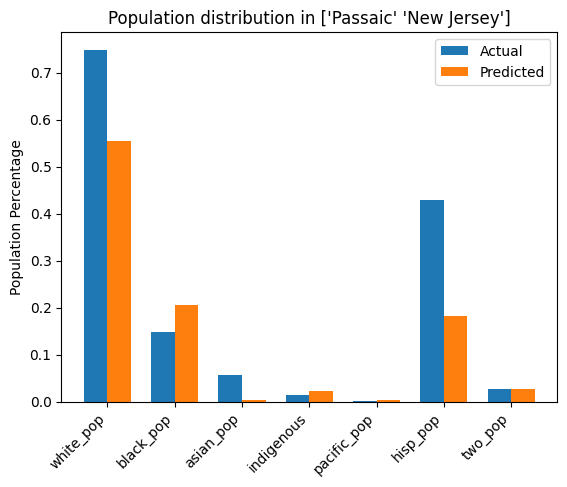

City: ['Barnstable' 'Massachusetts']
Predicted: [0.3100495  0.23839498 0.13745834 0.01447015 0.00277094 0.22879991
 0.06805627]
Actual: [9.2182261e-01 3.4579087e-02 1.5906850e-02 7.4839196e-03 6.2913750e-04
 3.3968732e-02 1.9578384e-02]


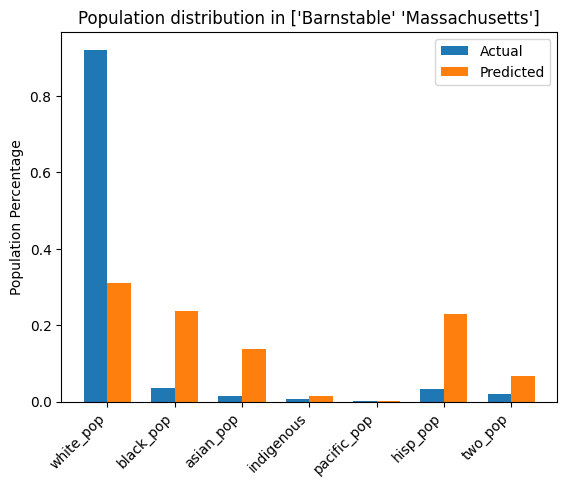

City: ['Jackson' 'Michigan']
Predicted: [0.5165708  0.2486803  0.05235451 0.00662804 0.0011982  0.1358165
 0.03875168]
Actual: [8.7603939e-01 8.1471197e-02 9.1666142e-03 4.3151854e-03 5.4255250e-04
 3.6433034e-02 2.8465081e-02]


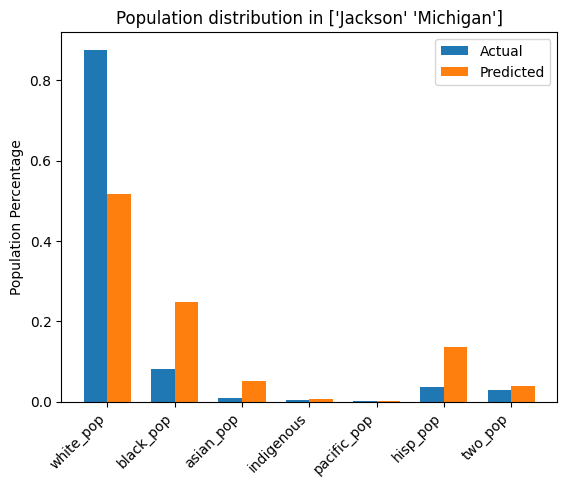

City: ['Monterey' 'California']
Predicted: [0.46799952 0.1722572  0.06732137 0.01992704 0.00382525 0.20759727
 0.0610723 ]
Actual: [0.8283513  0.03448824 0.06729469 0.02598252 0.00605214 0.59374374
 0.03783109]


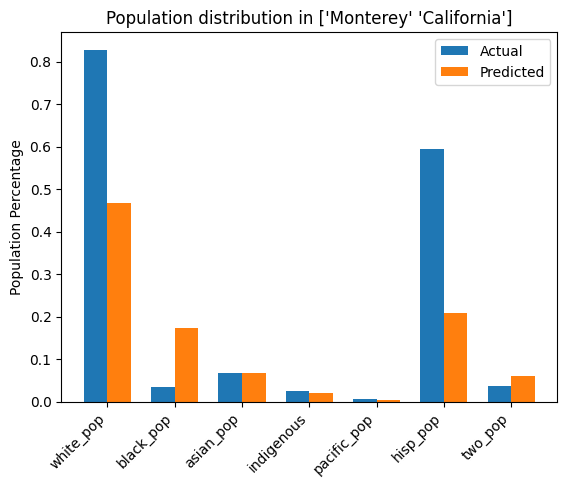

City: ['Burlington' 'New Jersey']
Predicted: [0.39529127 0.41104826 0.02602549 0.00915925 0.00189175 0.11247496
 0.044109  ]
Actual: [0.7286106  0.18303622 0.05415528 0.00341305 0.00088021 0.08533981
 0.02990464]


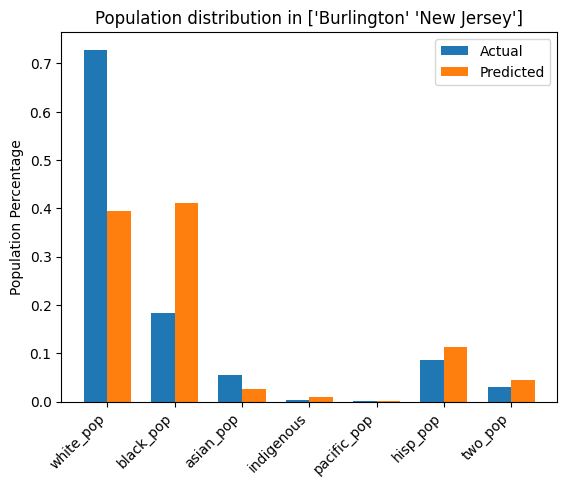

City: ['Kane' 'Illinois']
Predicted: [0.4829072  0.2740956  0.01638967 0.01007243 0.00184131 0.17646083
 0.03823299]
Actual: [8.6551917e-01 5.9935801e-02 4.3745060e-02 1.0242241e-02 8.0578058e-04
 3.2374161e-01 1.9751955e-02]


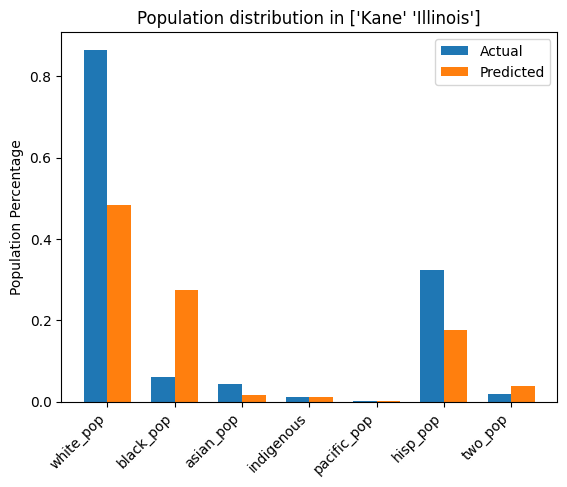

City: ['Montgomery' 'Alabama']
Predicted: [0.37196    0.28065386 0.17399418 0.00469157 0.00115549 0.12025424
 0.0472906 ]
Actual: [0.35508597 0.5932199  0.03277907 0.00337769 0.00094929 0.03684113
 0.0145881 ]


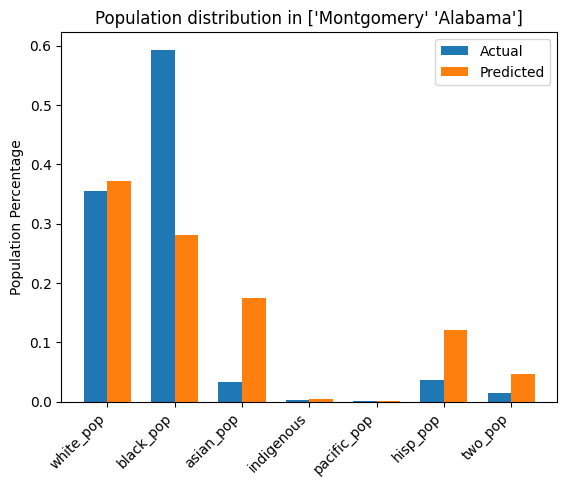

City: ['Monroe' 'Michigan']
Predicted: [0.4314896  0.25154004 0.11489554 0.00700699 0.00124591 0.1378268
 0.05599517]
Actual: [9.4313622e-01 2.6564784e-02 6.8837209e-03 3.9136214e-03 3.3222590e-04
 3.7481729e-02 1.9169435e-02]


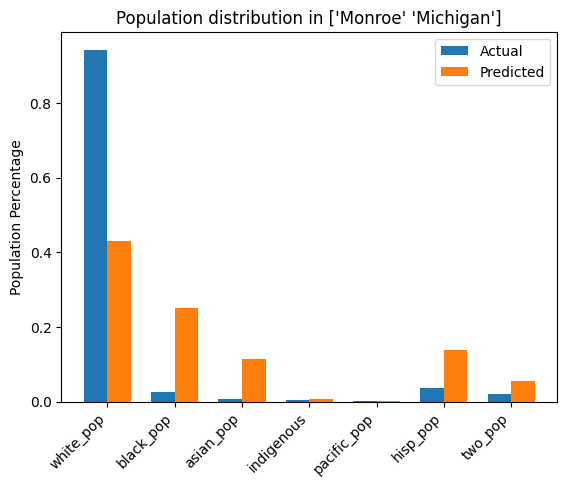

City: ['Kenosha' 'Wisconsin']
Predicted: [6.8610573e-01 7.8425035e-02 9.6541710e-02 3.5926935e-03 5.1540433e-04
 1.0517720e-01 2.9642267e-02]
Actual: [0.87201065 0.07413261 0.01760428 0.00753711 0.00100259 0.13456514
 0.02771274]


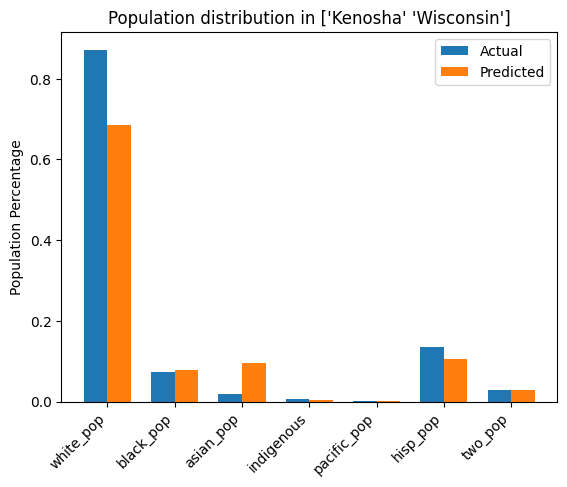

City: ['Butler' 'Pennsylvania']
Predicted: [1.9471999e-02 8.8023973e-01 4.4631097e-03 1.4725300e-03 2.1554409e-04
 8.4214576e-02 9.9225398e-03]
Actual: [9.5825994e-01 1.3617030e-02 1.4612489e-02 1.5863468e-03 3.6198518e-04
 1.6103016e-02 1.1562232e-02]


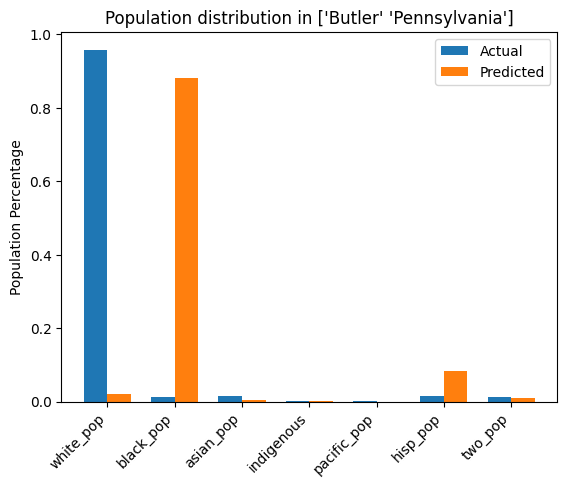

City: ['Tulare' 'California']
Predicted: [5.7663720e-02 1.1373897e-03 4.0244975e-04 1.1058517e-03 1.1775715e-05
 9.3813187e-01 1.5469545e-03]
Actual: [0.8816697  0.02182778 0.0397752  0.02774375 0.00229303 0.6560002
 0.02669055]


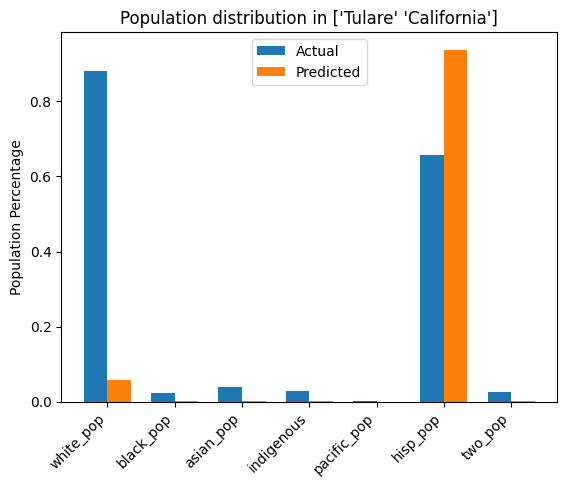

City: ['Hidalgo' 'Texas']
Predicted: [0.15186544 0.07120162 0.06865068 0.0198955  0.00100651 0.6634936
 0.02388665]
Actual: [9.6975046e-01 8.9178514e-03 1.0450014e-02 5.3965263e-03 4.6390784e-04
 9.2488605e-01 5.0212559e-03]


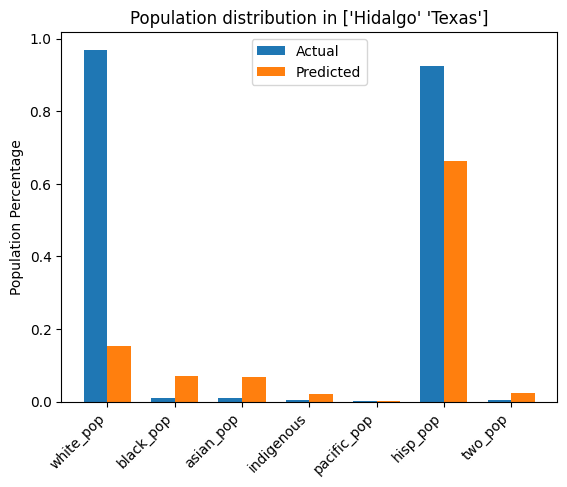

City: ['Pickens' 'South Carolina']
Predicted: [6.6955946e-02 2.9781908e-02 9.5081918e-02 3.0390578e-03 7.6949230e-04
 7.8170329e-01 2.2668445e-02]
Actual: [8.8610071e-01 7.1987011e-02 2.0010402e-02 2.9318118e-03 4.0194194e-04
 3.9406072e-02 1.8568141e-02]


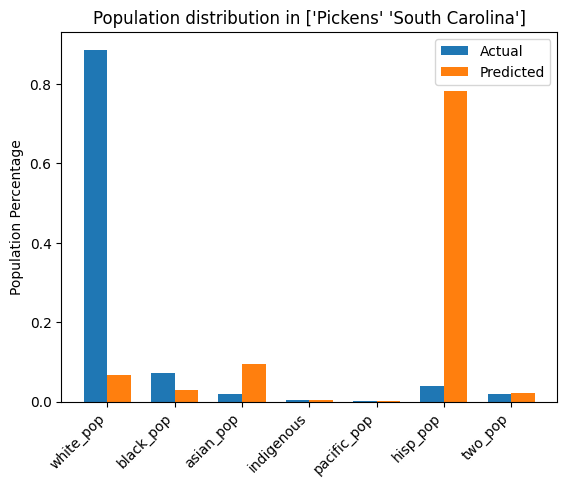

City: ['York' 'Pennsylvania']
Predicted: [0.75315905 0.0249672  0.01422803 0.00883215 0.00235692 0.17529161
 0.02116503]
Actual: [8.8677853e-01 7.0538774e-02 1.5238566e-02 3.7901562e-03 7.7050179e-04
 8.0757946e-02 2.2883458e-02]


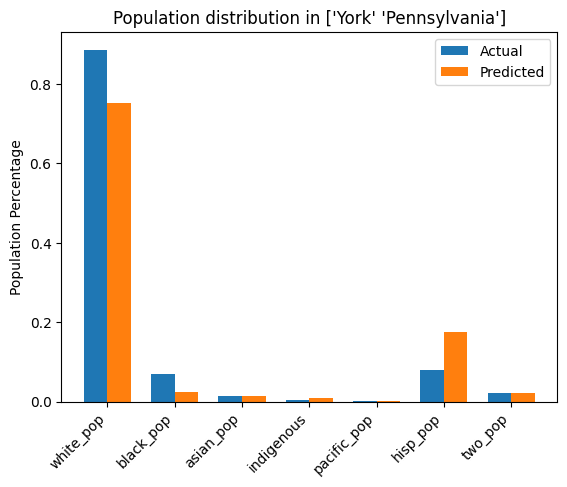

City: ['Dakota' 'Minnesota']
Predicted: [7.8853264e-02 1.3092910e-01 5.6581956e-01 1.4722208e-04 4.3236258e-05
 2.1052264e-01 1.3685013e-02]
Actual: [0.83622015 0.07488444 0.05219558 0.00620482 0.00095333 0.07557905
 0.02954168]


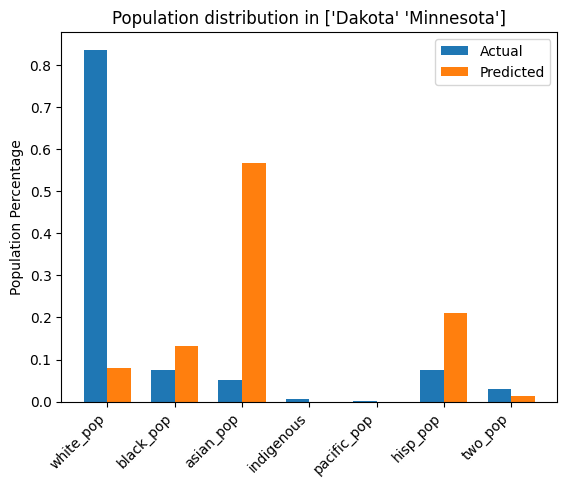

tensor(1.3555, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [121]:

model.eval()
predictions = model(X_test_tensor)
predictions = nn.functional.softmax(predictions, dim=1)
print(predictions.shape)

results = predictions.detach().numpy()
actuals = Y_test_tensor.detach().numpy()
cities = Y_city_state_test

# visualize the results
for i in range(15):
    print(f"City: {cities[i]}")
    print(f"Predicted: {results[i]}")
    print(f"Actual: {actuals[i]}")
    visualize(actuals[i], results[i], cities[i])


loss = criterion(predictions, Y_test_tensor)
print(loss)
